# **Importing Required Libraries**

This section includes all the necessary libraries and modules required for building, training, and converting a TensorFlow modelchine learning models.


In [58]:
# import all libraries !!
import os
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# **Defining Dataset Paths**

This code defines the paths for the input datasets (uveitis, stye, normal eyes) and the output directories where the processed and split datasets will be saved (train, validation, and test splits).


In [59]:
path_uveitis = '/kaggle/input/uveitis-disease'
path_stye = '/kaggle/input/stye-disease'
path_normal_eye = '/kaggle/input/normal-eye'


output_path_uveitis = '/kaggle/working/uveitis_split'
output_path_stye = '/kaggle/working/stye_split'
output_path_normal_eye = '/kaggle/working/normal_split'

#Check the contents of each source path
# print("Files in Uveitis source path:", os.listdir(path_uveitis))
# print("\nFiles in Stye source path:", os.listdir(path_stye))
# print("\nFiles in Normal Eye source path:", os.listdir(path_normal_eye))

# **Dataset Preparation**

This section handles the preparation of the dataset by:
1. Splitting the dataset into **train**, **validation**, and **test** subsets based on a specified ratio (default: 70%, 20%, 10%).
2. Validating the split directories to ensure files are correctly distributed.
3. Reorganizing the split datasets into a unified structure with category-wise folders under `train`, `validation`, and `test`.


In [60]:
def split_data(source_dir, output_dir, split_ratio=(0.7, 0.2, 0.1)):
    """
    Splits data into train, validation, and test datasets.
    
    Parameters:
        source_dir (str): Path to the source directory containing images.
        output_dir (str): Path to the output directory where splits will be stored.
        split_ratio (tuple): Tuple of (train_ratio, validation_ratio, test_ratio).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create subdirectories for train, validation, and test
    splits = ['train', 'validation', 'test']
    for split in splits:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
    # Get all files in the source directory
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    random.shuffle(files)
    
    # Calculate split indices
    total_files = len(files)
    train_idx = int(total_files * split_ratio[0])
    val_idx = train_idx + int(total_files * split_ratio[1])
    
    # Split files
    train_files = files[:train_idx]
    val_files = files[train_idx:val_idx]
    test_files = files[val_idx:]
    
    # Move files to their respective directories
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(output_dir, 'train', file))
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(output_dir, 'validation', file))
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(output_dir, 'test', file))
    
    print(f"Data split complete for {source_dir}.")
    print(f"Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")

In [61]:
# Split data first
split_data(path_uveitis, output_path_uveitis)
split_data(path_stye, output_path_stye)
split_data(path_normal_eye, output_path_normal_eye)

# Validate directories
def check_directory(path):
    if not os.path.exists(path):
        print(f"Directory {path} does not exist.")
    else:
        print(f"Contents of {path}:", os.listdir(path))

check_directory(output_path_uveitis)
check_directory(output_path_stye)
check_directory(output_path_normal_eye)

# Define and organize dataset
output_paths = {
    'uveitis': output_path_uveitis,
    'stye': output_path_stye,
    'normal': output_path_normal_eye
}
final_dataset_path = '/kaggle/working/dataset'

organize_dataset(output_paths, final_dataset_path)
print("Dataset successfully organized.")

Data split complete for /kaggle/input/uveitis-disease.
Train: 94, Validation: 27, Test: 14
Data split complete for /kaggle/input/stye-disease.
Train: 178, Validation: 51, Test: 26
Data split complete for /kaggle/input/normal-eye.
Train: 157, Validation: 45, Test: 23
Contents of /kaggle/working/uveitis_split: ['train', 'validation', 'test']
Contents of /kaggle/working/stye_split: ['train', 'validation', 'test']
Contents of /kaggle/working/normal_split: ['train', 'validation', 'test']
Moved 191_jpg.rf.963426a0e9a9d032e5112e9027ce3029.jpg to /kaggle/working/dataset/train/uveitis
Moved images-32_jpeg_jpg.rf.3493368570df78ecf20df9fb4f677a44.jpg to /kaggle/working/dataset/train/uveitis
Moved eyes_195_jpg.rf.b982501aedcb9b90685a9159d60642f6.jpg to /kaggle/working/dataset/train/uveitis
Moved images-2023-10-16T145437-745_jpeg_jpg.rf.574e738466d782c296182f2071b591cc.jpg to /kaggle/working/dataset/train/uveitis
Moved istockphoto-1179423833-612x612_jpg.rf.40ef5558c5553921f523d2ecdbf75501.jpg to /k

In [25]:
def organize_dataset(output_paths, final_dataset_path):
    for split in ['train', 'validation', 'test']:
        for category, output_path in output_paths.items():
            category_path = os.path.join(output_path, split)
            final_path = os.path.join(final_dataset_path, split, category)
            os.makedirs(final_path, exist_ok=True)
            
            # Check if category_path exists
            if not os.path.exists(category_path):
                print(f"Directory {category_path} does not exist. Skipping...")
                continue
            
            # Move files into the final structure
            for file in os.listdir(category_path):
                shutil.move(os.path.join(category_path, file), os.path.join(final_path, file))
                print(f"Moved {file} to {final_path}")

print("Contents of uveitis_split:", os.listdir(output_path_uveitis))
print("Contents of stye_split:", os.listdir(output_path_stye))
print("Contents of normal_split:", os.listdir(output_path_normal_eye))


Contents of uveitis_split: ['train', 'validation', 'test']
Contents of stye_split: ['train', 'validation', 'test']
Contents of normal_split: ['train', 'validation', 'test']


In [26]:
def organize_dataset_structure(output_paths, final_dataset_path):
    """
    Organizes all categories into a single dataset structure with train, validation, and test splits.
    
    Parameters:
        output_paths (dict): Dictionary mapping categories to their respective split output paths.
        final_dataset_path (str): Path to the final organized dataset folder.
    """
    for split in ['train', 'validation', 'test']:
        for category, output_path in output_paths.items():
            category_path = os.path.join(output_path, split)
            final_path = os.path.join(final_dataset_path, split, category)
            os.makedirs(final_path, exist_ok=True)
            
            # Move files into the final structure
            for file in os.listdir(category_path):
                shutil.move(os.path.join(category_path, file), os.path.join(final_path, file))
                print(f"Moved {file} to {final_path}")

# Define paths for the final dataset structure
output_paths = {
    'uveitis': '/kaggle/working/uveitis_split',
    'stye': '/kaggle/working/stye_split',
    'normal': '/kaggle/working/normal_split'
}
final_dataset_path = '/kaggle/working/dataset'

# Organize the dataset
organize_dataset(output_paths, final_dataset_path)
print("Dataset successfully organized.")

# Check the final dataset structure
print("Train Folders:", os.listdir(os.path.join(final_dataset_path, 'train')))
print("Validation Folders:", os.listdir(os.path.join(final_dataset_path, 'validation')))
print("Test Folders:", os.listdir(os.path.join(final_dataset_path, 'test')))

Dataset successfully organized.
Train Folders: ['uveitis', 'normal', 'stye']
Validation Folders: ['uveitis', 'normal', 'stye']
Test Folders: ['uveitis', 'normal', 'stye']


# **Model Training and Evaluation**

This section covers the following key steps:

1. **Defining the Model**:
   - Uses **MobileNetV2** as the base model with pre-trained weights from ImageNet.
   - Adds custom layers for classification: a global average pooling layer, a dense layer with ReLU activation, a dropout layer, and a final dense layer with softmax activation for multi-class classification.

2. **Data Augmentation**:
   - Applies transformations such as rotation, zoom, shift, and horizontal flips to increase dataset variability and improve model generalization.

3. **Training the Model**:
   - Compiles the model using the Adam optimizer with a learning rate of 0.0001.
   - Uses early stopping to prevent overfitting, monitoring validation loss with a patience of 100 epochs.
   - Trains the model on the augmented dataset while tracking accuracy and loss for training and validation.

4. **Evaluation**:
   - Plots the training and validation accuracy and loss to visualize the model's performance over epochs.

5. **Saving the Model**:
   - Saves the trained model in **H5 format** for future use or deployment.

In [31]:
# Define the base model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# Define the full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust the number of classes
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Learning rate for transfer learning
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [62]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training and validation data
train_data = datagen.flow_from_directory(
    '/kaggle/working/dataset/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_data = datagen.flow_from_directory(
    '/kaggle/working/dataset/validation',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data = datagen.flow_from_directory(
    os.path.join(final_dataset_path, 'test'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 564 images belonging to 3 classes.
Found 224 images belonging to 3 classes.
Found 121 images belonging to 3 classes.


In [42]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)


In [43]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 418ms/step - accuracy: 0.8111 - loss: 0.4678 - val_accuracy: 0.8049 - val_loss: 0.4597
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - accuracy: 0.7980 - loss: 0.5008 - val_accuracy: 0.8211 - val_loss: 0.5053
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.7870 - loss: 0.4979 - val_accuracy: 0.7724 - val_loss: 0.5611
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.7964 - loss: 0.5171 - val_accuracy: 0.7398 - val_loss: 0.6317
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.8032 - loss: 0.5064 - val_accuracy: 0.7724 - val_loss: 0.5231
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 402ms/step - accuracy: 0.8705 - loss: 0.4084 - val_accuracy: 0.7886 - val_loss: 0.5373
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - accuracy: 0.8074 - loss: 0.4763 - val_accuracy: 0.8049 - val_loss: 0.5049
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - accuracy: 0.8082 - loss: 0.5159 - val_ac

In [44]:
# Load test data
test_data = datagen.flow_from_directory(
    '/kaggle/working/dataset/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 63 images belonging to 3 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.8633 - loss: 0.3301
Test Loss: 0.3145960867404938
Test Accuracy: 0.8730158805847168


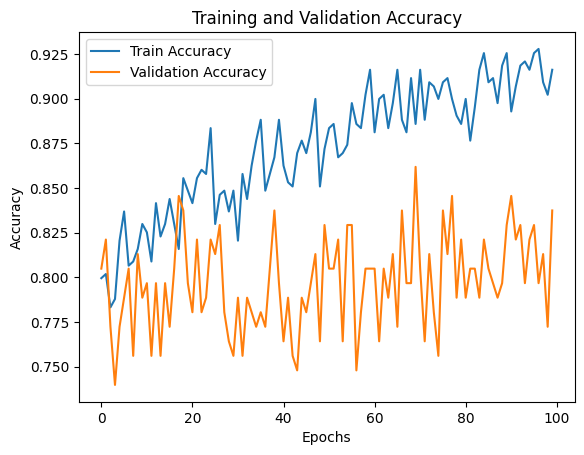

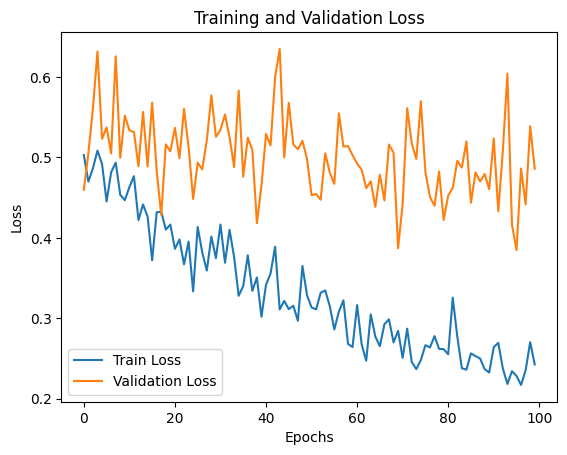

In [45]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [55]:
# Save the model in H5 format
model.save('/kaggle/working/model.h5')
print("Model saved as model.h5")


Model saved as model.h5


# **Converting Model to TensorFlow.js Format**

This step converts the trained model from **H5 format** to **TensorFlow.js format** for use in web-based applications. 


In [49]:
# Install tensorflowjs

!pip install tensorflowjs

  Using cached tensorflowjs-4.22.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflow-2.16.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow_decision_forests-1.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)
  Using cached tf_keras-2.18.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflowjs-4.22.0-py3-none-any.whl (89 kB)
Using cached tensorflow_decision_forests-1.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
Using cached tf_keras-2.18.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.16.0
    Uninstalling tf_keras-2.16.0:
      Successfully uninstalled tf_keras-2.16.0
  Attempting uninstall: tensorflow-decision-forests
    Found existing installation: te

In [57]:
# convert model.h5 to json
#!tensorflowjs_converter --input_format=keras model.h5 tfjs_model
!tensorflowjs_converter --input_format=keras /kaggle/working/model.h5 /kaggle/working/tfjs_model


2024-12-03 20:05:52.384426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733256352.426304    2025 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733256352.437954    2025 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
